# Models
The following classification models are carried out here:
    1. Random Forest
    2. Nested Logit

In [2]:
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

# oversampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

# 1. Load in data

In [3]:
X_16 = pd.read_csv('../../../Data/model_inputs/gdf_2016_X.csv')
y_16 = pd.read_csv('../../../Data/model_inputs/gdf_2016_y.csv')
X_17 = pd.read_csv('../../../Data/model_inputs/gdf_2017_X.csv')
y_17 = pd.read_csv('../../../Data/model_inputs/gdf_2017_y.csv')

In [4]:
## remove variables based on discussions
## TODO: remove from all_preprocessing
removed_vars = ['magnitude','carddir','downtown_s','downtown_e','startx','starty','endx',\
                'endy','hour','land_use_s','land_use_e']
X_16 = X_17.drop(removed_vars,axis=1)
X_17 = X_17.drop(removed_vars,axis=1)

In [11]:
X_17.columns

Index(['id_trip', 'mode', 'duration', 'distance_m', 'weekday', 'temp_clus',
       'precip', 'temp', 'morning', 'midday', 'afternoon', 'evening',
       'midnight'],
      dtype='object')

In [5]:
def boolean_to_num(row):
    if row:
        return 1
    else:
        return 0
if not type(X_16['morning'][0]) == np.int64:
    print('changing booleans to numbers')
    for col in ['morning','midday','afternoon','evening','midnight']:
        X_16[col] = X_16[col].apply(boolean_to_num)
        X_17[col] = X_17[col].apply(boolean_to_num)

changing booleans to numbers


##### Dependent variable class sizes
Purpose: {'leisure': 0, 'food_drink': 1, 'shops': 2, 'pick_up_drop_off': 3, 'education': 4, 'health': 5}
Mode: {'walking': 0, 'public_transport': 1, 'car': 2, 'cycling': 3, 'public_transport, car': 4, 'other': 5}

In [6]:
print('Dependent variable class sizes 2016:')
y_16['purpose'].value_counts()

Dependent variable class sizes 2016:


0    7430
1    5790
2    5682
3    2473
4    2262
5    2168
Name: purpose, dtype: int64

In [7]:
print('Dependent variable class sizes 2017:')
y_17['purpose'].value_counts()

Dependent variable class sizes 2017:


0    8049
2    7723
1    2714
4    2175
3    1379
5     908
Name: purpose, dtype: int64

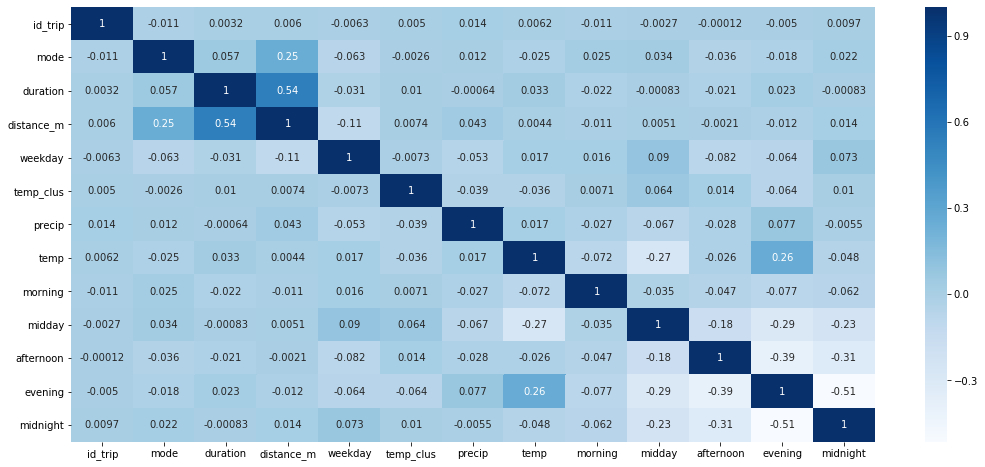

In [8]:
ax, fig = plt.subplots(1, figsize=(18,8))
sns.heatmap(X_16.corr(), cmap='Blues', annot=True)

# 2. Setup model
#### Section Overview:
2.1  Split data into training and testing  
2.2  Calculate p_nearby
2.3  Remove trip ID's from train/test data  

In [113]:
combined_X = pd.concat([X_16, X_17],axis=0)
combined_y = pd.concat([y_16, y_17],axis=0)
combined_X.reset_index(drop=True, inplace=True)
combined_y.reset_index(drop=True, inplace=True)

In [114]:
# check for no duplicates
combined_X.id_trip.value_counts()

67583     2
442011    2
287854    2
11887     2
327285    2
         ..
447010    2
156537    2
95099     2
84860     2
4098      2
Name: id_trip, Length: 22948, dtype: int64

In [115]:
# check for no duplicates
combined_y.purpose.value_counts()

0    15479
2    13405
1     8504
4     4437
3     3852
5     3076
Name: purpose, dtype: int64

In [116]:
# define main data
all_X = combined_X.copy()
all_y = combined_y.copy()

### 2.1 Split data into training and testing

In [117]:
def normalise(X, to_normalize):
    """
        Feature scaling method.
        Normalises an array between 0–1 using the Z-score
        (i - min) / (max - min)
    """
    for col in X.columns[to_normalize]:
        row_min = X[col].min()
        row_max = X[col].max()
        X[col] = X[col].apply(lambda row: (row - row_min)/(row_max - row_min))
    return X
    

def model_setup(X, y, test_size=0.33, norm=False, to_normalise=[]):
    """
        All operations needed for preparing the model inputs.
        Can apply normalisation and then will apply the train/test split
    """
    if norm:
        X = normalise(X, to_normalise)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=test_size,\
                                                                                random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test    

##### IMPORTANT
Train Test Split for encoded and non-encoded

In [118]:
non_categorical_features = [False,False,True,True,True,False,False,False,False,False,True,\
                        True,False,False,False,False,False,False,False,False,False,False,False,False]

In [13]:
all_X.columns[non_categorical_features]

Index(['duration', 'distance_m', 'magnitude', 'precip', 'temp'], dtype='object')

In [14]:
# Train Test Split
X_train, X_test, y_train, y_test  = model_setup(all_X, all_y, norm=True, test_size=0.33, to_normalise=non_categorical_features)



In [15]:
X_train.head()

,id_trip,mode,duration,distance_m,magnitude,carddir,downtown_s,downtown_e,weekday,temp_clus,...,endx,endy,hour,morning,midday,afternoon,evening,midnight,land_use_s,land_use_e
13051,3592784,2,0.015505,0.015059,0.935970,3,1,1,1,1,...,7.629632e+06,1.252537e+06,16,0,0,1,0,0,1,1
37551,152350,2,0.048111,0.034086,0.169275,0,0,0,1,4,...,7.620944e+06,1.265901e+06,23,0,0,0,0,1,1,1
7582,1959960,2,0.156737,0.138435,0.677456,11,1,0,0,4,...,7.616296e+06,1.245143e+06,19,0,0,0,1,0,1,5
48160,204665,2,0.126010,0.027076,0.555760,13,1,1,1,2,...,7.627373e+06,1.251307e+06,21,0,0,0,1,0,4,0
30591,123314,3,0.077711,0.031316,0.315754,15,1,1,1,1,...,7.631133e+06,1.244680e+06,13,0,1,0,0,0,0,6


## 2.2 Calculate p_nearby
Proportion of other trips that ended nearby with a given purpose

Purpose: {'leisure': 0, 'food_drink': 1, 'shops': 2, 'pick_up_drop_off': 3, 'education': 4, 'health': 5}


In [16]:
# initialise the geo dataframes needed
all_X['geometry'] = all_X.apply(lambda row: shapely.geometry.Point(row['endx'],row['endy']),axis=1)
geo_df = gpd.GeoDataFrame(pd.concat([all_X,all_y],axis=1))
geo_df.crs = {'init':'epsg:3347'} # Canada Lambert Projection

In [18]:
# only purposes of points around training are known  
all_train = pd.concat([X_train,pd.DataFrame(y_train, columns=['purpose'])],axis=1)
geo_X_train = all_train.copy()
geo_X_train.reset_index(drop=True,inplace=True)

In [19]:
geo_X_train['geometry'] = geo_X_train.apply(lambda row: shapely.geometry.Point(row['endx'],row['endy']),axis=1)
geo_df_train = gpd.GeoDataFrame(geo_X_train)
geo_df_train.crs = {'init':'epsg:3347'}

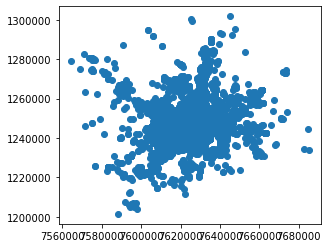

In [20]:
geo_df_train.plot()

In [21]:
# calculate 200 m buffers around each trip end point
geo_df['buffers'] = geo_df['geometry'].apply(lambda row: row.buffer(200))

In [22]:
# get dataframe with only buffers and purposes
all_buffers = geo_df[['id_trip','buffers','purpose']]
geo_df.drop('buffers',axis=1,inplace=True)
all_buffers = gpd.GeoDataFrame(all_buffers.rename(columns={'buffers':'geometry'}))
all_buffers.crs = {'init': 'epsg:3347'}

In [23]:
%%time
joined_data = gpd.sjoin(all_buffers, geo_df_train, op='intersects', how='left')

CPU times: user 28.4 s, sys: 2.18 s, total: 30.6 s
Wall time: 36 s


In [24]:
print(len(joined_data))
joined_data.tail()

2219087


,id_trip_left,geometry,purpose_left,index_right,id_trip_right,mode,duration,distance_m,magnitude,carddir,...,endy,hour,morning,midday,afternoon,evening,midnight,land_use_s,land_use_e,purpose_right
48752,333364,"POLYGON ((7614336.832987057 1237383.977932138,...",2,1577.0,176152.0,2.0,0.116050,0.063887,0.236482,1.0,...,1.237374e+06,20.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0
48752,333364,"POLYGON ((7614336.832987057 1237383.977932138,...",2,7936.0,50177.0,2.0,0.059293,0.025514,0.195892,11.0,...,1.237374e+06,21.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0
48752,333364,"POLYGON ((7614336.832987057 1237383.977932138,...",2,14898.0,2048905.0,3.0,0.012028,0.006100,0.608697,6.0,...,1.237383e+06,11.0,0.0,1.0,0.0,0.0,0.0,5.0,5.0,0.0
48752,333364,"POLYGON ((7614336.832987057 1237383.977932138,...",2,6401.0,2209132.0,2.0,0.100357,0.025408,0.603153,5.0,...,1.237383e+06,19.0,0.0,0.0,0.0,1.0,0.0,5.0,5.0,4.0
48752,333364,"POLYGON ((7614336.832987057 1237383.977932138,...",2,24234.0,27836.0,2.0,0.220259,0.340667,0.473881,14.0,...,1.237384e+06,22.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [25]:
%%time
to_drop = joined_data[['id_trip_left','id_trip_right']].apply(lambda row: True \
                                                                if row['id_trip_left'] == row['id_trip_right']\
                                                                else False, axis=1)

CPU times: user 44.8 s, sys: 290 ms, total: 45.1 s
Wall time: 45.8 s


In [26]:
to_drop[:5]

0    False
0    False
0    False
0    False
0    False
dtype: bool

In [27]:
# get rid of duplicate trips
joined_data = joined_data[~to_drop]

In [28]:
# see if duplicates have been dropped (check if more than one trip ID shows)
joined_data.loc[joined_data['id_trip_left'] == 2386427]

,id_trip_left,geometry,purpose_left,index_right,id_trip_right,mode,duration,distance_m,magnitude,carddir,...,endy,hour,morning,midday,afternoon,evening,midnight,land_use_s,land_use_e,purpose_right
21325,2386427,"POLYGON ((7617980.680022833 1251490.953635337,...",2,26384.0,7311.0,2.0,0.137286,0.170948,0.284044,2.0,...,1.251486e+06,13.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5.0


In [29]:
grouped_data = joined_data.groupby(['id_trip_left', 'purpose_right']).agg({'mode':'count'})
grouped_data = grouped_data.apply(lambda g: g / g.sum(), axis=1).reset_index()
grouped_data = grouped_data.pivot(index='id_trip_left',columns='purpose_right')['mode'].fillna(0.0).reset_index()

grouped_data.columns = ['id_trip','p_nearby_leisure','p_nearby_food','p_nearby_shops','p_nearby_pickup','p_nearby_education',\
                       'p_nearby_health']

In [30]:
print('num of trips without other trips around:', all_X['id_trip'].nunique() - grouped_data['id_trip'].nunique())

num of trips without other trips around: 2386


In [31]:
grouped_data.head()

,id_trip,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health
0,7,1.052315e-05,0.000011,0.000013,9.150562e-07,5.947866e-06,1.830112e-06
1,21,6.405394e-06,0.000002,0.000005,2.745169e-06,0.000000e+00,9.150562e-07
2,67,4.575281e-07,0.000000,0.000004,9.150562e-07,4.575281e-07,4.575281e-07
3,86,9.150562e-06,0.000008,0.000013,3.660225e-06,9.150562e-07,4.117753e-06
4,115,1.830112e-06,0.000000,0.000002,1.372584e-06,4.575281e-07,4.575281e-07


In [32]:
# join the data back to the all_X
if not 'p_nearby_leisure' in all_X.columns:
    print('merging')
    all_X = all_X.merge(grouped_data, on='id_trip', how='left')
    all_X = all_X.fillna(0.0)

merging


In [33]:
if 'geometry' in all_X.columns:
    print('removing geometry')
    all_X.drop('geometry', axis=1, inplace=True)

removing geometry


In [34]:
all_X.head(2)

,id_trip,mode,duration,distance_m,magnitude,carddir,downtown_s,downtown_e,weekday,temp_clus,...,evening,midnight,land_use_s,land_use_e,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health
0,1889461,1,0.036365,0.017995,0.940044,0,1,1,1,2,...,1,0,0,0,0.000019,3.660225e-06,1.601348e-05,4.575281e-07,9.150562e-07,0.000001
1,2071991,3,0.073670,0.027212,0.447575,1,1,1,1,3,...,1,0,1,4,0.000007,4.575281e-07,4.575281e-07,0.000000e+00,4.575281e-07,0.000001


### 2.2.1 re-join the props back to train test

In [35]:
if not 'p_nearby_leisure' in X_train.columns:
    print('merging data')
    col_to_merge = ['id_trip', 'p_nearby_leisure','p_nearby_food','p_nearby_shops',\
                        'p_nearby_pickup','p_nearby_education','p_nearby_health']
    X_train = X_train.merge(all_X[col_to_merge], on='id_trip')
    X_test = X_test.merge(all_X[col_to_merge], on='id_trip')

merging data


In [37]:
X_train.head()

,id_trip,mode,duration,distance_m,magnitude,carddir,downtown_s,downtown_e,weekday,temp_clus,...,evening,midnight,land_use_s,land_use_e,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health
0,3592784,2,0.015505,0.015059,0.935970,3,1,1,1,1,...,0,0,1,1,0.000000e+00,4.575281e-07,4.575281e-07,4.575281e-07,4.575281e-07,0.000000e+00
1,152350,2,0.048111,0.034086,0.169275,0,0,0,1,4,...,0,1,1,1,4.575281e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.575281e-07
2,1959960,2,0.156737,0.138435,0.677456,11,1,0,0,4,...,1,0,1,5,0.000000e+00,9.150562e-07,0.000000e+00,9.150562e-07,0.000000e+00,0.000000e+00
3,204665,2,0.126010,0.027076,0.555760,13,1,1,1,2,...,1,0,4,0,4.575281e-07,4.575281e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,123314,3,0.077711,0.031316,0.315754,15,1,1,1,1,...,0,0,0,6,1.052315e-05,1.052315e-05,1.235326e-05,3.202697e-06,4.072000e-05,3.202697e-06


In [36]:
X_test.head()

,id_trip,mode,duration,distance_m,magnitude,carddir,downtown_s,downtown_e,weekday,temp_clus,...,evening,midnight,land_use_s,land_use_e,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health
0,2715767,2,0.032043,0.021728,0.496629,11,1,1,0,4,...,0,0,6,1,0.000002,4.575281e-07,0.000000,4.575281e-07,0.000000e+00,0.000000
1,2403724,1,0.017008,0.021340,0.972933,13,0,0,1,2,...,1,0,5,5,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
2,444946,3,0.089457,0.025674,0.813082,6,1,1,1,2,...,0,1,0,2,0.000012,7.320450e-06,0.000008,1.830112e-06,2.928180e-05,0.000002
3,3127597,2,0.009397,0.011322,0.847318,12,1,1,1,2,...,0,0,1,1,0.000002,4.117753e-06,0.000005,3.660225e-06,9.150562e-07,0.000002
4,3396409,5,0.074140,0.019809,0.717441,13,0,1,1,3,...,0,0,5,3,0.000022,1.464090e-05,0.000009,1.372584e-06,3.843236e-05,0.000005


## 2.3  Remove trip ID's and other columns

In [46]:
# drop unneeded features
X_train = X_train.drop(['startx','starty','endx','endy','hour'],axis=1)
X_test = X_test.drop(['startx','starty','endx','endy','hour'],axis=1)

In [47]:
# keep training ids
training_ids = X_train['id_trip'].copy()
X_train = X_train.drop('id_trip', axis=1)
testing_ids = X_test['id_trip'].copy()
X_test = X_test.drop('id_trip', axis=1)


In [48]:
X_train.columns

Index(['mode', 'duration', 'distance_m', 'magnitude', 'carddir', 'downtown_s',
       'downtown_e', 'weekday', 'temp_clus', 'precip', 'temp', 'morning',
       'midday', 'afternoon', 'evening', 'midnight', 'land_use_s',
       'land_use_e', 'p_nearby_leisure', 'p_nearby_food', 'p_nearby_shops',
       'p_nearby_pickup', 'p_nearby_education', 'p_nearby_health',
       'startclust', 'endclust'],
      dtype='object')

In [49]:
## flatten data i.e. from Pd.Series to np.array
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [50]:
feature_list = list(X_train.columns)
print('all_features:\n\n', feature_list)

all_features:

 ['mode', 'duration', 'distance_m', 'magnitude', 'carddir', 'downtown_s', 'downtown_e', 'weekday', 'temp_clus', 'precip', 'temp', 'morning', 'midday', 'afternoon', 'evening', 'midnight', 'land_use_s', 'land_use_e', 'p_nearby_leisure', 'p_nearby_food', 'p_nearby_shops', 'p_nearby_pickup', 'p_nearby_education', 'p_nearby_health', 'startclust', 'endclust']


# 3. Begin Modelling
#### Section Overview:
3.1 Define model functions and test modelling   
3.2 Preliminary modelling for important feature extraction  
3.3 Re-run models  

#### Model functions:
- `run_rf` == run the random forest classification model.
- `run_sv` == run the support vector machine classification model.
- `run_ann` == run the multi-layer perceptron classification model.  
- `run_mcrf` == *Experimental* run the multi-output random forest classification model.

#### Notes:

#### Technical Notes:
- each model will have a cross-validation option. To use this the function parameters will need to be set to `cv=True` and `cv_val` to the number of k-folds defaulting to `cv_val=5`

### 3.1 Define model functions and test

In [51]:
# All Model functions
def run_rf(X_train, X_test, y_train, y_test, n_estimators=128, cv=False, cv_val=5):
    """
        Run a random forest classification model with option to use cross-validation
    """
    cv_scores = []
    if cv:
        clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators)
        cv_scores = sklearn.model_selection.cross_val_score(clf, X_train, y_train, cv=cv_val)
        print("cv scores:",cv_scores)
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    score = clf.score(X_test,y_test)
    preds = clf.predict(X_test)
    print("Random Forest Classifcation accuracy:", score)
    return clf, score, preds, cv_scores


#### 3.1.1 test models

In [52]:
%%time
_, _, _, _ = run_rf(X_train, X_test, y_train, y_test, cv=False)

Random Forest Classifcation accuracy: 0.5255764808254086
CPU times: user 11.1 s, sys: 357 ms, total: 11.5 s
Wall time: 11.9 s


In [53]:
%%time
_, _, _, _ = run_rf(X_train, X_test, y_train, y_test, cv=True, cv_val=10)

cv scores: [0.51216154 0.51783254 0.50183711 0.51691931 0.52534068]
Random Forest Classifcation accuracy: 0.5271303374976692
CPU times: user 49.9 s, sys: 1.43 s, total: 51.3 s
Wall time: 55.4 s


### 3.2 Subset data by feature importance metric

In [57]:
def feature_selection(model, X_train, X_test, y_train, y_test, threshold):
    model.fit(X_train, y_train)
    print("model score before feature extraction: ", model.score(X_test, y_test))
    perm = PermutationImportance(model).fit(X_test, y_test)
    
    
    # perm.feature_importances_ attribute is now available, it can be used
    # for feature selection - let's e.g. select features which increase
    # accuracy by at least 0.01:
    X_train_subset = X_train[X_train.columns[perm.feature_importances_ > threshold]]
    X_test_subset = X_test[X_test.columns[perm.feature_importances_ > threshold]]
    
    return model, X_train_subset, X_test_subset, perm
    

In [58]:
## EXAMPLE OF USE
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=10, n_jobs=-1)

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
perm = PermutationImportance(clf).fit(X_test, y_test)
# perm.feature_importances_ attribute is now available, it can be used
# for feature selection - let's e.g. select features which increase
# accuracy by at least 0.01:
sel = SelectFromModel(perm, threshold=0.01, prefit=True)
X_test.columns[perm.feature_importances_ > 0.01]

0.46976194915780967


Index(['mode', 'distance_m', 'weekday', 'precip', 'temp', 'midnight',
       'land_use_e', 'p_nearby_leisure', 'p_nearby_food', 'p_nearby_shops',
       'p_nearby_pickup', 'p_nearby_education', 'p_nearby_health'],
      dtype='object')

In [100]:
X_train.columns[10]

'temp'

In [59]:
%%time
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=128, n_jobs=-1)
clf, X_train_subset, X_test_subset, perm = feature_selection(clf, X_train, X_test, y_train, y_test,threshold=0.01)
eli5.show_weights(perm)

model score before feature extraction:  0.5291192740381627
CPU times: user 2min 15s, sys: 3.53 s, total: 2min 19s
Wall time: 55.8 s


Weight,Feature
0.0783 ± 0.0020,x20
0.0620 ± 0.0020,x22
0.0604 ± 0.0053,x0
0.0421 ± 0.0034,x18
0.0352 ± 0.0030,x15
0.0320 ± 0.0028,x7
0.0292 ± 0.0048,x10
0.0200 ± 0.0024,x2
0.0173 ± 0.0034,x19
0.0152 ± 0.0012,x21


In [60]:
print('important columns:\n',X_test.columns[[18,19,20,22,0,15]])

important columns:
 Index(['p_nearby_leisure', 'p_nearby_food', 'p_nearby_shops',
       'p_nearby_education', 'mode', 'midnight'],
      dtype='object')


In [61]:
X_train_subset.head()

,mode,distance_m,weekday,temp,midnight,land_use_e,p_nearby_leisure,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health
0,2,0.015059,1,0.333150,0,1,0.000000e+00,4.575281e-07,4.575281e-07,4.575281e-07,4.575281e-07,0.000000e+00
1,2,0.034086,1,0.775837,1,1,4.575281e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.575281e-07
2,2,0.138435,0,0.415893,0,5,0.000000e+00,9.150562e-07,0.000000e+00,9.150562e-07,0.000000e+00,0.000000e+00
3,2,0.027076,1,0.418278,0,0,4.575281e-07,4.575281e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,3,0.031316,1,0.513285,0,6,1.052315e-05,1.052315e-05,1.235326e-05,3.202697e-06,4.072000e-05,3.202697e-06


### 3.3 Re-build the models with new subset data

#### Note:

purpose = {'leisure': 0, 'food_drink': 1, 'shops': 2, 'pick_up_drop_off': 3, 'education': 4, 'health': 5}  

In [62]:
rf_clf, rf_score, rf_preds, rf_cv_scores = run_rf(X_train_subset, X_test_subset, y_train, y_test)

Random Forest Classifcation accuracy: 0.5020200136739387


In [63]:
print('predictions for each class by RF:', collections.Counter(rf_preds), '\n')
# {'leisure': 0, 'food_drink': 1, 'shops': 2,
# 'pick_up_drop_off': 3, 'education': 4, 'health': 5}
print(sklearn.metrics.classification_report(y_test, rf_preds))

predictions for each class by RF: Counter({0: 6792, 2: 4854, 1: 2123, 4: 1239, 3: 562, 5: 519}) 

              precision    recall  f1-score   support

           0       0.50      0.67      0.58      5108
           1       0.41      0.31      0.35      2807
           2       0.51      0.56      0.53      4424
           3       0.42      0.19      0.26      1271
           4       0.67      0.57      0.62      1464
           5       0.49      0.25      0.33      1015

    accuracy                           0.50     16089
   macro avg       0.50      0.42      0.44     16089
weighted avg       0.50      0.50      0.49     16089



# 4 Improve models
### Overview:
4.1 Encode model inputs (for ANN/SVC)   
4.2 Re-run models with encoded inputs  
4.3 Oversample  
4.4 add POI categories to model  

### 4.1 Encode model inputs
The model inputs are encoded to improve the performance of ANN/SVC models. Specifically by One-hot encoding all the 

#### Encoded inputs:
- Trip mode *(f)*
- Cardinal Direction *(f)*
- Trip starting & ending cluster from K-means (see `./Notebooks/preprocessing/metric_creation/clustering.ipynb`)
- Temporal cluster from LDA
- Land-use at trip starting and ending points *(f)* (see `./Notebooks/preprocessing/metric_creation/land_use_poi.ipynb`)

*(f) == factors*

#### Note:
- for factor numbers see Data/model_inputs folder e.g. `./Data/model_inputs/gdf_2016_land_use_factors.txt`

In [68]:
# for One Hot Encoded data
enc_X_train = X_train_subset.copy()
enc_X_test = X_test_subset.copy()
enc_y_train = pd.DataFrame(y_train, columns=['purpose']).copy()
enc_y_test = pd.DataFrame(y_test, columns=['purpose']).copy()

In [69]:
def encode_model_inputs(data, col):
    """
        function for applying a OneHotEncoder to a input feature 
    """
    encoded_input = ''
    if col in data.columns:
        encoded_input = enc.fit_transform(data[col].values.reshape(-1, 1)).toarray()
    return encoded_input


In [70]:
enc = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')


In [71]:
encoded_inputs_train = {}
encoded_inputs_test = {}
for col in ["mode"]:
    if col in enc_X_train.columns:
        # 1. encode inputs
        encoded_inputs_train[col] = encode_model_inputs(enc_X_train, col)
        encoded_inputs_test[col] = encode_model_inputs(enc_X_test, col)
        # 2. make a temporary df with encoded inputs and column names of format *col*_*factor*
        col_df_train = pd.DataFrame(encoded_inputs_train[col], columns=['%s_%s' % (col, i) for i in range(encoded_inputs_train[col].shape[1])])
        col_df_test = pd.DataFrame(encoded_inputs_test[col], columns=['%s_%s' % (col, i) for i in range(encoded_inputs_test[col].shape[1])])
        # 3. drop column from main data so that they can be concatenated
        enc_X_train = enc_X_train.drop(col, axis=1)
        enc_X_test = enc_X_test.drop(col, axis=1)
        # 4. concatenate the two data sets
        enc_X_train = pd.concat([enc_X_train, col_df_train], axis=1)
        enc_X_test = pd.concat([enc_X_test, col_df_test], axis=1)

encoded_inputs_train['purpose'] = encode_model_inputs(enc_y_train, 'purpose')
encoded_inputs_test['purpose'] = encode_model_inputs(enc_y_test, 'purpose')

In [72]:
# view new data with columns following the *col*_*factor* syntax
enc_X_train.columns

Index(['distance_m', 'weekday', 'temp', 'midnight', 'p_nearby_leisure',
       'p_nearby_food', 'p_nearby_shops', 'p_nearby_pickup',
       'p_nearby_education', 'p_nearby_health', 'mode_0', 'mode_1', 'mode_2',
       'mode_3', 'mode_4', 'mode_5', 'land_use_e_0', 'land_use_e_1',
       'land_use_e_2', 'land_use_e_3', 'land_use_e_4', 'land_use_e_5',
       'land_use_e_6', 'land_use_e_7', 'land_use_e_8', 'land_use_e_9'],
      dtype='object')

# 4.3 Oversample
## 4.3.1 Load in data

In [80]:
# oversampled_X_16 = pd.read_csv('../../../Data/model_inputs/oversampled_X_2016.csv')
# oversampled_y_16 = pd.read_csv('../../../Data/model_inputs/oversampled_y_2016.csv')
# oversampled_X_17 = pd.read_csv('../../../Data/model_inputs/oversampled_X_2017.csv')
# oversampled_y_17 = pd.read_csv('../../../Data/model_inputs/oversampled_y_2017.csv')

In [81]:
oversampled_y_16.purpose.value_counts()

5    7430
4    7430
3    7430
2    7430
1    7430
0    7430
Name: purpose, dtype: int64

In [82]:
oversampled_y_17.purpose.value_counts()

5    8049
4    8049
3    8049
2    8049
1    8049
0    8049
Name: purpose, dtype: int64

## 4.3.2 prepare data
after section 2.

In [166]:
all_X_over = pd.concat([oversampled_X_16, oversampled_X_17],axis=0)
all_y_over = pd.concat([oversampled_y_16, oversampled_y_17],axis=0)
all_X_over.reset_index(drop=True, inplace=True)
all_y_over.reset_index(drop=True, inplace=True)

In [270]:
# initialise the geo dataframes needed
all_X['geometry'] = all_X.apply(lambda row: shapely.geometry.Point(row['endx'],row['endy']),axis=1)
geo_df = gpd.GeoDataFrame(pd.concat([all_X,all_y],axis=1))
geo_X_train = X_train.copy()
geo_X_train.reset_index(drop=True,inplace=True)
geo_X_train['geometry'] = geo_X_train.apply(lambda row: shapely.geometry.Point(row['endx'],row['endy']),axis=1)

geo_df_train = gpd.GeoDataFrame(pd.concat([geo_X_train,pd.DataFrame(y_train, columns=['purpose'])],axis=1))
geo_df.crs = {'init':'epsg:3347'} # Canada Lambert Projection
geo_df_train.crs = {'init':'epsg:3347'}

In [271]:
geo_df['buffers'] = geo_df['geometry'].apply(lambda row: row.buffer(200))

In [272]:
all_buffers = geo_df[['id_trip','buffers','purpose']]

In [273]:
all_buffers = geo_df[['id_trip','buffers','purpose']]
geo_df.drop('buffers',axis=1,inplace=True)

In [274]:
all_buffers = geo_df[['id_trip','buffers','purpose']]
geo_df.drop('buffers',axis=1,inplace=True)
all_buffers = gpd.GeoDataFrame(all_buffers.rename(columns={'buffers':'geometry'}))
all_buffers.crs = {'init': 'epsg:3347'}

In [275]:
all_buffers = geo_df[['id_trip','buffers','purpose']]
geo_df.drop('buffers',axis=1,inplace=True)
all_buffers = gpd.GeoDataFrame(all_buffers.rename(columns={'buffers':'geometry'}))
all_buffers.crs = {'init': 'epsg:3347'}
%%time
joined_data = gpd.sjoin(geo_df, all_buffers, op='intersects', how='left')

CPU times: user 42.2 s, sys: 7.72 s, total: 49.9 s
Wall time: 1min 7s


In [277]:
joined_data.head()

,id_trip_left,mode,duration,distance_m,magnitude,carddir,downtown_s,downtown_e,weekday,temp_clus,...,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health,geometry,purpose_left,index_right,id_trip_right,purpose_right
0,1889461,1,0.036365,0.017995,0.940044,0,1,1,1,2,...,0.087912,0.384615,0.010989,0.021978,0.032967,POINT (7630297.958008135 1248128.900960694),0,9187,2470190,2
0,1889461,1,0.036365,0.017995,0.940044,0,1,1,1,2,...,0.087912,0.384615,0.010989,0.021978,0.032967,POINT (7630297.958008135 1248128.900960694),0,22124,2365463,2
0,1889461,1,0.036365,0.017995,0.940044,0,1,1,1,2,...,0.087912,0.384615,0.010989,0.021978,0.032967,POINT (7630297.958008135 1248128.900960694),0,20333,3439108,2
0,1889461,1,0.036365,0.017995,0.940044,0,1,1,1,2,...,0.087912,0.384615,0.010989,0.021978,0.032967,POINT (7630297.958008135 1248128.900960694),0,43085,51196,0
0,1889461,1,0.036365,0.017995,0.940044,0,1,1,1,2,...,0.087912,0.384615,0.010989,0.021978,0.032967,POINT (7630297.958008135 1248128.900960694),0,48317,248295,0


In [297]:

%%time
to_drop = joined_data[['id_trip_left','id_trip_right']].apply(lambda row: True \
                                                                if row['id_trip_left'] == row['id_trip_right']\
                                                                else False, axis=1)

CPU times: user 1min 9s, sys: 617 ms, total: 1min 10s
Wall time: 1min 12s


In [301]:

to_drop[:5]

0    False
0    False
0    False
0    False
0    False
dtype: bool

In [305]:
# get rid of duplicate trips
joined_data = joined_data[~to_drop]

In [313]:
joined_data.loc[joined_data['id_trip_left'] == 2386427]

,id_trip_left,mode,duration,distance_m,magnitude,carddir,downtown_s,downtown_e,weekday,temp_clus,...,p_nearby_food,p_nearby_shops,p_nearby_pickup,p_nearby_education,p_nearby_health,geometry,purpose_left,index_right,id_trip_right,purpose_right
21325,2386427,2,0.134749,0.145423,0.227609,11,0,0,0,2,...,0.0,0.5,0.0,0.0,0.5,POINT (7617780.680022833 1251490.953635337),2,33527,7311,5


In [369]:
grouped_data = joined_data.groupby(['id_trip_left', 'purpose_right']).agg({'mode':'count'})
grouped_data = grouped_data.apply(lambda g: g / g.sum()).reset_index()
grouped_data = grouped_data.pivot(index='id_trip_left',columns='purpose_right')['mode'].fillna(0.0).reset_index()


In [370]:
grouped_data

purpose_right,id_trip_left,0,1,2,3,4,5
0,7,1.105471e-05,1.197594e-05,1.351131e-05,9.212260e-07,6.755657e-06,1.228301e-06
1,21,5.220280e-06,1.535377e-06,3.991979e-06,1.842452e-06,3.070753e-07,6.141506e-07
2,67,9.212260e-07,0.000000e+00,2.763678e-06,9.212260e-07,6.141506e-07,3.070753e-07
3,86,8.598109e-06,7.062732e-06,1.074764e-05,3.684904e-06,9.212260e-07,3.377829e-06
4,115,1.228301e-06,0.000000e+00,2.149527e-06,1.228301e-06,6.141506e-07,6.141506e-07
5,148,4.913205e-06,2.763678e-06,7.369808e-06,0.000000e+00,0.000000e+00,1.535377e-06
6,171,3.070753e-06,0.000000e+00,0.000000e+00,3.070753e-07,3.070753e-07,3.070753e-07
7,175,3.070753e-06,2.763678e-06,3.684904e-06,9.212260e-07,2.149527e-06,1.228301e-06
8,183,3.377829e-06,0.000000e+00,1.228301e-06,3.070753e-07,0.000000e+00,0.000000e+00
9,186,1.842452e-06,3.070753e-06,2.456603e-06,9.212260e-07,3.070753e-07,1.228301e-06


In [169]:
if not type(all_X_over['downtown_s'][0]) == np.int64:
    print('changing booleans to numbers')
    for col in ['downtown_s','downtown_e','morning','midday','afternoon','evening','midnight']:
        all_X_over[col] = all_X_over[col].apply(boolean_to_num)

changing booleans to numbers


In [170]:
# Train Test Split
X_train, X_test, y_train, y_test  = model_setup(all_X_over, all_y_over, norm=False, test_size=0.33,\
                                                to_normalise=non_categorical_features)


In [64]:
## Prepare Data
training_ids = X_train['id_trip']
X_train = X_train.drop('id_trip', axis=1)
testing_ids = X_test['id_trip']
X_test = X_test.drop('id_trip', axis=1)

## Flatten data i.e. from Pd.Series to np.array
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

## Keep feature list
feature_list = list(X_train.columns)
print('all_features:\n\n', feature_list)

all_features:

 ['mode_f', 'duration', 'distance_m', 'magnitude', 'carddir_f', 'start_down', 'end_downto', 'weekday', 'temporal_c', 'precip', 'temperatur', 'startrush', 'endrush', 'thrurush', 'startclust', 'endclust', 'land_use_s_f', 'land_use_e_f']


In [65]:
len(X_train)

120407

In [66]:
run_rf(X_train, X_test, y_train, y_test)

Random Forest Classifcation accuracy: 0.7353680128151083


(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                        oob_score=False, random_state=None, verbose=0,
                        warm_start=False),
 0.7353680128151083,
 array([7, 1, 3, ..., 0, 1, 3]),
 [])